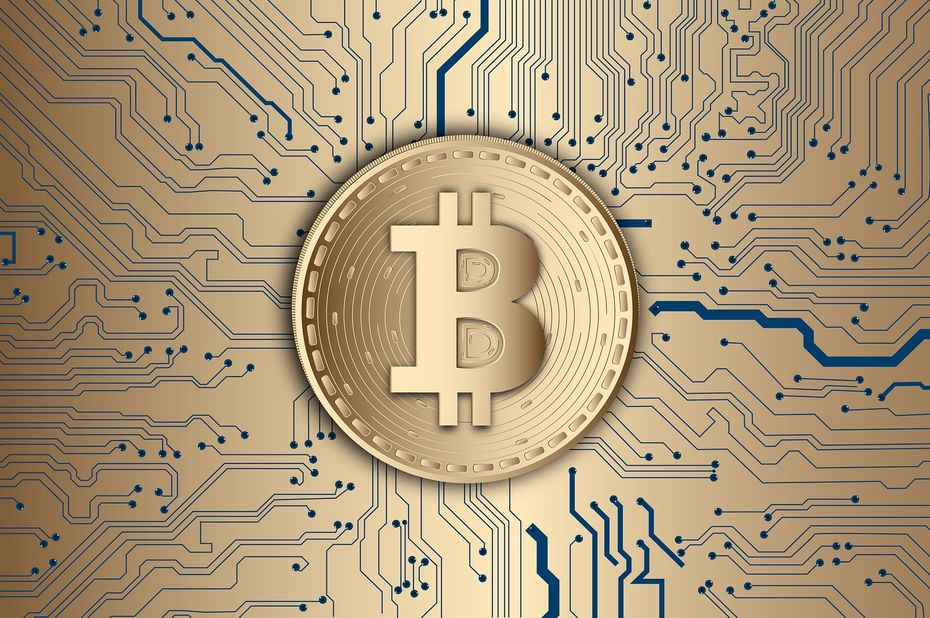

In [ ]:
# Probabilistic forecasting using GluonTS: BTC

Prévision probabiliste à l'aide de GluonTS : exemple BTC
La prévision probabiliste, plutôt que de fournir une prévision ponctuelle, fournit une distribution de probabilité comme résultat. Pour ce faire, nous utiliserons le package GluonTS - Probabilistic Time Series Modeling

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor

#plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 12})
#plt.rcParams["figure.figsize"] = (12, 4)
from datetime import date
from gluonts.dataset.common import ListDataset

import math
from math import ceil
# Error libs
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import max_error
from sklearn.metrics import median_absolute_error
#from sklearn.metrics import mean_poisson_deviance
from sklearn.metrics import mean_gamma_deviance
from sklearn.metrics import mean_tweedie_deviance
from math import sqrt

/usr/local/lib/python3.7/dist-packages/gluonts/json.py:46: UserWarning:

Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.



In [ ]:
import sys
RED   = "\033[1;31m"  
BLUE  = "\033[1;34m"
CYAN  = "\033[1;36m"
GREEN = "\033[0;32m"

In [ ]:
crypto_df=pd.read_csv('/content/drive/MyDrive/14_NEW PROJECT CRYPTO/gresearch_crypto/train.csv')

In [ ]:
crypto_df.head(10)

,timestamp,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
0,1514764860,2,40.0,2376.580000,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
1,1514764860,0,5.0,8.530000,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2,1514764860,1,229.0,13835.194000,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
3,1514764860,5,32.0,7.659600,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
4,1514764860,7,5.0,25.920000,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
5,1514764860,6,173.0,738.302500,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
6,1514764860,9,167.0,225.330000,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
7,1514764860,11,7.0,329.090000,329.8800,329.0900,329.460000,6.635710,329.454118,NaN
8,1514764920,2,53.0,2374.553333,2400.9000,2354.2000,2372.286667,24.050259,2371.434498,-0.004079
9,1514764920,0,7.0,8.530000,8.5300,8.5145,8.514500,71.390000,8.520215,-0.015875


**timestamp**: All timestamps are returned as second Unix timestamps (the number of seconds elapsed since 1970-01-01 00:00:00.000 UTC). Timestamps in this dataset are multiple of 60, indicating minute-by-minute data

**Asset_ID**: The asset ID corresponding to one of the crytocurrencies (e.g. Asset_ID = 1 for Bitcoin). The mapping from Asset_ID to crypto asset is contained in asset_details.csv

**Count**: Total number of trades in the time interval (last minute)

**Open**: Opening price of the time interval (in USD)

**High**: Highest price reached during time interval (in USD)

**Low**: Lowest price reached during time interval (in USD)

**Close**: Closing price of the time interval (in USD)

**Volume**: Quantity of asset bought or sold, displayed in base currency USD

**VWAP**: The average price of the asset over the time interval, weighted by volume. VWAP is an aggregated form of trade data // Le prix moyen de l'actif sur l'intervalle de temps, pondéré par le volume. Le VWAP est une forme agrégée de données commerciales

**Target**: Residual log-returns for the asset over a 15 minute horizon

In [ ]:
asset_details = pd.read_csv('/content/drive/MyDrive/14_NEW PROJECT CRYPTO/gresearch_crypto/asset_details.csv')
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [ ]:
# extract the data corresponding to ethereum (Asset_ID = 6)
btc = crypto_df.query("Asset_ID == 2").reset_index(drop = True)
btc['timestamp'] = pd.to_datetime(btc['timestamp'], unit='s')
btc = btc.set_index('timestamp')
# extract the "High" value at 9:00 a.m. daily
indexer_9am = btc.index.indexer_at_time('9:00:00')
values_at_9am = btc.iloc[indexer_9am]
high_values_at_9am = values_at_9am[["High"]]
# take a look
high_values_at_9am

,High
timestamp,
2018-01-01 09:00:00,2365.90
2018-01-02 09:00:00,2384.70
2018-01-03 09:00:00,2662.99
2018-01-04 09:00:00,2367.22
2018-01-05 09:00:00,2359.00
...,...
2021-09-16 09:00:00,641.23
2021-09-17 09:00:00,646.01
2021-09-18 09:00:00,635.99


In [ ]:
#Create Model -> Nous prévoyons trois mois (30 jours) de données, sur la base des 180 jours précédant le début de la période de prévision

freq = "1D"             # la fréquence de nos données, ici quotidiennement
context_length    = 180 # train sur ce nombre de jours
prediction_length =  30 # predict days, ceux-ci sont retirés de la fin de l'entrainement


In [ ]:
#Convertion dataframe en dataset  GluonTS
data_list = [{"start": "2018-01-01 09:00:00", "target": high_values_at_9am[c].values} for c in high_values_at_9am.columns]  ### BTC
train_ds  = ListDataset(data_iter=data_list,freq="1D")

In [ ]:
# Training
#Ici, nous utilisons l'estimateur de réseau neuronal pré-construit de GulonTS, SimpleFeedForwardEstimator, en conjonction avec un entraîneur.
# Ce réseau feedforward peut se substituer à un réseau neuronal récurrent (RNN), tel que le DeepAREstimator.

In [ ]:
from gluonts.model.simple_feedforward  import SimpleFeedForwardEstimator
# to use the DeepAREstimator 
# from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.distribution.student_t import StudentTOutput
from gluonts.mx import Trainer

In [ ]:
estimator = SimpleFeedForwardEstimator(num_hidden_dimensions=[60],
                                       freq=freq,
                                       context_length=context_length,
                                       prediction_length=prediction_length,
                                       distr_output=StudentTOutput(),
                                       trainer=Trainer(epochs=50,
                                                       learning_rate=1e-3,
                                                       num_batches_per_epoch=100,
                                                       patience=10))

predictor = estimator.train(train_ds)
print("Done")

100%|██████████| 100/100 [00:01<00:00, 95.32it/s, epoch=50/50, avg_epoch_loss=5.83]

Done


In [ ]:
#Prediction
#Nous allons maintenant faire (ici 2000) des prédictions à l'aide de notre modèle
from gluonts.evaluation import make_evaluation_predictions

forecast_it, ts_it = make_evaluation_predictions(
    dataset=train_ds,  # dataset
    predictor=predictor,  # predictor
    num_samples=2000,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)

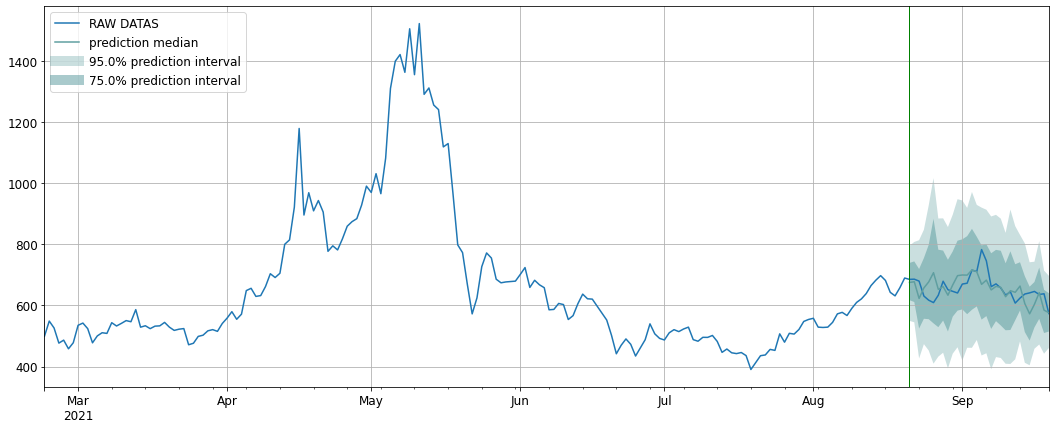

In [ ]:
# Visualisation
# nous allons maintenant tracer notre prévision probabiliste (ici avec les intervalles de prévision de 50% et 90% indiqués) avec les valeurs de vérité terrain

def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = context_length + prediction_length
    prediction_intervalle = (75.0, 95.0)
    legend = ["RAW DATAS", "prediction median "] + [f"{k}% prediction interval" for k in prediction_intervalle][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(18, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervalle, color='cadetblue')
    plt.axvline(forecast_entry.start_date, color='g', lw=1) # end of train dataset
    plt.grid(which="major")
    plt.legend(legend, loc="upper left")
    plt.show();
    
plot_prob_forecasts(tss[0], forecasts[0])

In [ ]:
# Nous pouvons extraire les valeurs moyennes et médianes de nos prévisions comme suit :
forecast_entry = forecasts[0]
sys.stdout.write(GREEN)
print(f"Mean of the future window:\n {forecast_entry.mean}")
print(f"0.5-quantile (median) of the future window:\n {forecast_entry.quantile(0.5)}")

Mean of the future window:
 [676.68335 677.42426 621.9384  657.6394  679.5888  709.9604  654.18134
 663.1847  632.9279  668.0149  699.1406  697.3105  698.1023  717.4472
 710.0066  672.67676 682.91547 648.6969  664.931   658.3951  629.4432
 648.87714 643.31604 661.76227 605.51025 574.6904  603.07855 640.1519
 582.193   577.60315]
0.5-quantile (median) of the future window:
 [675.4586  677.69525 622.9782  657.5868  677.11206 707.4412  652.78314
 661.8753  633.59534 667.31903 697.6783  699.8499  699.3516  716.4308
 710.45636 669.27167 683.0698  650.9806  662.4834  659.2651  628.7149
 648.3912  643.11725 663.5859  606.0125  572.7134  603.78705 642.02625
 584.69324 576.28546]


In [ ]:
sys.stdout.write(GREEN)
ControlTrain=high_values_at_9am.iloc[-30:,:]
ControlTrain["Prediction"]=forecast_entry.mean
ControlTrain

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,High,Prediction
timestamp,,
2021-08-22 09:00:00,685.46,676.683350
2021-08-23 09:00:00,686.15,677.424255
2021-08-24 09:00:00,679.78,621.938416
2021-08-25 09:00:00,630.86,657.639404
2021-08-26 09:00:00,617.27,679.588806
2021-08-27 09:00:00,609.37,709.960388
2021-08-28 09:00:00,633.63,654.181335
2021-08-29 09:00:00,679.36,663.184692
2021-08-30 09:00:00,651.64,632.927917


In [ ]:
# Evaluations
class errors:
      
    def mean_absolute_percentage(y, y_hat): 
        
        #y_true=y_true.replace(0,0.001)
        #y_pred=y_pred.replace(0,0.001)
        y, y_hat = np.array(y), np.array(y_hat)
        return np.mean(np.abs((y - y_hat) / y)) * 100    
    
    def mean_absolute_percentage_notabs(y, y_hat): 
        
        #y_true=y_true.replace(0,0.001)
        #y_pred=y_pred.replace(0,0.001)
        #y, y_hat = np.array(y), np.array(y_hat)
        return np.mean(((y - y_hat) / y)) * 100    
    
    def bias(y,yhat):    
        y, y_hat = np.array(y), np.array(y_hat)
        return np.sum(y - y_hat)
        
    def smape(y_true, y_pred):
        denominator = (np.abs(y_true) + np.abs(y_pred))
        diff = np.abs(y_true - y_pred) / denominator
        diff[denominator == 0] = 0.0
        return 200 * np.mean(diff)
    def performance_metrics (y,yhat):
        #print("y shape : ",y.shape , " , y_hat shape : ", yhat.shape)
        try:
            '''
            R² is the ratio entre la qualité de notre modèle et la qualité du modèle moyen naïf
            '''
            R_2 = round(r2_score(y, yhat),3)                
        except:
            R_2 = "EXC" 
            
        '''
        Adjusted R2 required Regressor Number
        '''

        try:
            '''
            Explained variance regression score function
            '''
            EVS = round(explained_variance_score(y, yhat),3)
        except:
            EVS = "EXC"  
            
        try:
            '''
            Mean absolute error regression loss
            Pas aussi sensible aux valeurs aberrantes que l'erreur quadratique moyenne.
            MAE est plus robuste (moins sensible aux valeurs aberrantes) que MSE
            La mesure donne une idée de l'ampleur de l'erreur, mais aucune idée de la direction (par exemple, sur ou sous-prédiction).
            '''
            MAE = int(mean_absolute_error(y, yhat))                   
        except:
            MAE = "EXC" 
            
        try:
            '''
            Mean squared error regression loss
            MSE mesure essentiellement l'erreur quadratique moyenne de nos prédictions. Pour chaque point, il calcule la différence carrée entre les prédictions et la cible, puis fait la moyenne de ces valeurs.
            Plus cette valeur est élevée, plus le modèle est mauvais. Ce n'est jamais négatif, puisque nous élevons au carré les erreurs individuelles de prédiction avant de les additionner, mais ce serait zéro pour un modèle parfait .
            Avantage : Utile si nous avons des valeurs inattendues dont nous devrions nous soucier. Valeur très élevée ou faible à laquelle nous devons prêter attention.
            Inconvénient : Si nous faisons une seule très mauvaise prédiction, la quadrature aggravera l'erreur et cela peut fausser la métrique vers une surestimation de la méchanceté du modèle. C'est un comportement particulièrement problématique si nous avons des données bruitées (c'est-à-dire des données qui
            pour une raison quelconque n'est pas entièrement fiable) — même un modèle « parfait » peut avoir un MSE élevé dans cette situation, il devient donc difficile de juger de la performance du modèle. En revanche, si toutes les erreurs sont petites, ou plutôt inférieures à 1, alors le
            l'effet inverse se fait sentir : on peut sous-estimer la méchanceté du modèle.
            Notez que si nous voulons avoir une prédiction constante, la meilleure sera la valeur moyenne des valeurs cibles. Il peut être trouvé en réglant la dérivée de notre erreur totale par rapport à cette constante à zéro, et en la trouvant à partir de cette équation.
            '''
            MSE = int(mean_squared_error(y, yhat))                   
        except:
            MSE = "EXC" 
            
        try:    
            '''
            RMSE
            '''
            RMSE = round(mean_squared_error(y, yhat, squared=False),2)
        except: 
            RMSE = "EXC" 
            
        try:
            '''
            The bias est defini comme l'erreur moyenne
            '''
            BIAS = int (bias(y,yhat))
        except:
            BIAS = "EXC" 
            
        try:
            
            MAPE= round(errors.mean_absolute_percentage(y, yhat),2)         
        except:
            MAPE= "EXC" 
            
        try:
            '''  	
            max_error metric calcules le maximum du résidu
            '''            
            MAXE = round (max_error(y, yhat),2)
        except:            
            MAXE ="EXC"
            
        try:            
            '''
            Mean squared logarithmic error regression loss
            '''
            MSLE = round(mean_squared_log_error(y, yhat),2)
        except:            
            MSLE ="EXC"
        try:            
            '''
            Median absolute error regression loss
            '''
            MDAE = round(median_absolute_error(y, yhat),2)
        except:            
            MDAE ="EXC"
        try:            
            '''
            Mean Poisson Deviance
            '''
            MPD = 0 # round(mean_poisson_deviance(y, yhat),2)
        except:            
            MPD ="EXC"
            
        try:            
            '''
            Mean Gamma Deviance
            '''
            MGD = round(mean_gamma_deviance(y, yhat),2)
        except:            
            MGD ="EXC"
            
        try:            
            '''
            Mean Tweedie Deviance
            '''
            MTD = round(mean_tweedie_deviance(y, yhat),2)
        except:            
            MTD ="EXC"
        try:            
            '''
            SMAPE
            '''
            SMAPE = round(smape(y, yhat),2)
        except:            
            SMAPE ="EXC"     
        
        return R_2, EVS, MAE, MSE, RMSE, BIAS, MAPE, MTD, MGD, MPD, MSLE, MDAE, MAXE, SMAPE
    
    
    
    def results_dict (y,yhat):
        
        R_2, EVS, MAE, MSE, RMSE, BIAS, MAPE, MTD, MGD, MPD, MSLE, MDAE, MAXE,SMAPE= errors.performance_metrics (y,yhat)
        
        return {'r2' : R_2 , 'evs' : EVS , 'mae' : MAE , 'mse' : MSE , 'mape' : MAPE, 'rmse' : RMSE, 'bias' : BIAS, 'mtd' : MTD, 'mgd' : MGD, 'mpd' : MPD, 'msle' : MSLE, 'mdae' : MDAE, 'maxe' : MAXE, "smape": SMAPE}
    
    
    
    def print_results(y,y_hat):
        
        R_2, EVS, MAE, MSE, RMSE, BIAS, MAPE, MTD, MGD, MPD, MSLE, MDAE, MAXE,SMAPE = errors.performance_metrics (y,y_hat)
        print ('----------------------------------------------------------------')
        print ('                        MODEL ERROR METRICS                     ')
        print ('----------------------------------------------------------------')
        print ("- R2 Score                       (R^2) = " + str (R_2) )
        print ("- Explained Variance Score       (EVS) = " + str (EVS) )
        print ("- Mean Absolute Error            (MAE) = " + str (MAE) )
        print ("- Mean Squared Error             (MSE) = " + str (MSE) )
        print ("- Mean Absolute Percentage Error (MAPE)= %" + str (MAPE))
        print ("- Root Mean Squared Error        (RMSE)= " + str (RMSE))
        print ("- BIAS...SUM(y-yhat)             (BIAS)= " + str (BIAS))
        print ("- Mean Tweedie Deviance          (MTD) = " + str (MTD) )
        print ("- Mean Gamma Deviance            (MGD) = " + str (MGD) )
        print ("- Mean Poisson Deviance          (MPD) = " + str (MPD) )
        print ("- Mean squared logarithmic Error (MSLE)= " + str (MSLE))     
        print ("- Median absolute Error          (MDAE)= " + str (MDAE))        
        print ("- Maximum Residual Error         (MAXE)= " + str (MAXE))
        print ("-  S Mean Absolute Percentage Error (SMAPE)= %" + str (SMAPE))
        
        print ('----------------------------------------------------------------')
        print ('\n')

In [ ]:
sys.stdout.write(RED)
errors.print_results(ControlTrain.High,ControlTrain.Prediction)

----------------------------------------------------------------
                        MODEL ERROR METRICS                     
----------------------------------------------------------------
- R2 Score                       (R^2) = -0.046
- Explained Variance Score       (EVS) = -0.043
- Mean Absolute Error            (MAE) = 31
- Mean Squared Error             (MSE) = 1802
- Mean Absolute Percentage Error (MAPE)= %4.74
- Root Mean Squared Error        (RMSE)= 42.46
- BIAS...SUM(y-yhat)             (BIAS)= EXC
- Mean Tweedie Deviance          (MTD) = 1802.56
- Mean Gamma Deviance            (MGD) = 0.0
- Mean Poisson Deviance          (MPD) = 0
- Mean squared logarithmic Error (MSLE)= 0.0
- Median absolute Error          (MDAE)= 23.47
- Maximum Residual Error         (MAXE)= 110.44
-  S Mean Absolute Percentage Error (SMAPE)= %EXC
----------------------------------------------------------------


